In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import scipy.sparse
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers

# Gradient Based Image Blending
In this notebook you will implement gradient based image blending, which was originaly was described in the paper [Poisson Image Editing]( https://www.cs.virginia.edu/~connelly/class/2014/comp_photo/proj2/poisson.pdf). The goal of gradient based image blending is to copy a region of one image (source image) into another image (target image) without creating visible seams at the edge of the region.

**NOTE** In this exercise, we implement a version of the gradient based image blending scheme that is a bit simpler than what was discussed in the lecture. The difference is that we do not need to distinguish between inner and boundary gradients but only need one gradient matrix for the region to be filled.

As was covered in the lecture, the idea behind gradient based image blending is to find new pixel values such that the gradients of the source image are retained while making sure that there is no visible seam at the boundary of the avected region. We will now define this more formally. Let $I$ denote the set of pixels of the region to be filled, $B$ the set of boundary pixels and $g_i$ and $\tilde{g_i}$ denote the output and source gradients within the region to be filled respectively.

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = \sum\limits_{i \in I} {\lvert g_i - \tilde{g_i} \rvert}^2 + c_{\tilde{u}} \sum\limits_{i \in B} {\lvert U - \tilde{U_t} \rvert}^2
\end{align}
$$

We can rewrite $f(U)$ using only matrix operations. Let $S$ be the selector matrix which selects all pixels on the boundary, $U$ the vector containing the output pixel values (in the region to be filled), $\tilde{U_s}$ the source pixel values (in the region to be filled) and $\tilde{U_t}$ the target pixel values (in the region to be filled). Let $G$ be the gradient matrix for the region to be filled. With the the gradient defined as  $g=GU$ we can derive the following quadratic polynomial:

$$
f(U) = {\lvert GU - G\tilde{U_s} \rvert}^2 + c_{\tilde{u}} {\lvert SU - S\tilde{U_t} \rvert}^2 \\
f(U) = (U^TG^T - \tilde{U_s}^TG^T) (GU-G\tilde{U_s}) + c_{\tilde{u}} (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) = U^T(G^TG)U - 2U^T(G^TG\tilde{U_s}) + \tilde{U_s}^TG^TG\tilde{U_s} + c_{\tilde{u}} (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}^TS^TS\tilde{U_t}) \\
f(U) = U^T(G^TG + c_{\tilde{u}} S^TS)U - 2U^T(G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}) + \tilde{U_s}^TG^TG\tilde{U_s} + c_{\tilde{u}} \tilde{U_t}^TS^TS\tilde{U_t} \\
$$

We want to minimize the objective function and we know that at the minimum the derivative $f'(U)=0$. Using this knoweldge we can transform the problem into a linear system:

$$
f'(U) = 2(G^TG + c_{\tilde{u}} S^TS)U - 2(G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}) = 0 \\
(G^TG + c_{\tilde{u}} S^TS)U = G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t} \\
%(L + c_{\tilde{u}} S^TS)U = L\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}
$$

### Initialization
The following code loads the images that we will use for the image blending exercises.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
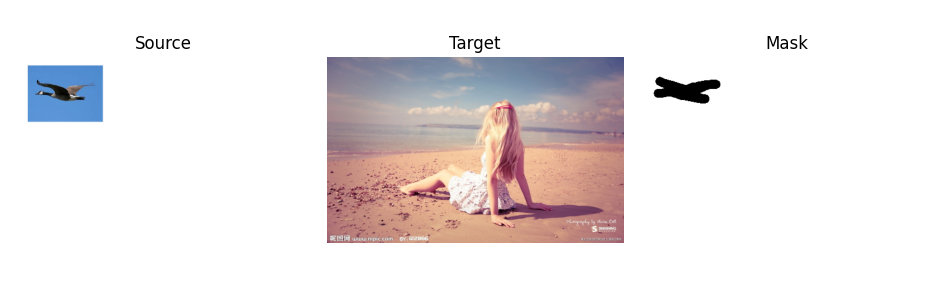

In [4]:
swan_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "swan.jpg"), 0.5)
beach_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "beach.jpg"), 0.5)
swan_beach_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "mask.jpg"), 0.5)
swan_beach_mask = (swan_beach_mask < 0.5)

helpers.show_images({ "Source": swan_image_color, "Target": beach_image_color,  "Mask": swan_beach_mask}, nrows=1, ncols=3)

## Exercise 3 (1 point)
Implement a function that returns the gradient matrix G. This matrix when multiplied by the (single color channel) image vector should result in a vector with all the gradients, both horizontal & vertical, between neighbouring pixels which are both **inside the mask** (pixels at which `mask[y,x] != 0`). We define the gradient between a pixel $U_i$ and neighbouring pixel $U_j$ as $\frac{1}{2} (U_j - U_i)$. Use `scipy.sparse.lil_matrix((num_rows, num_columns))` to construct a sparse matrix and convert it to `scipy.sparse.csr_matrix` before returning it. **Please refer to the image sharpening notebook on the order in which the gradients should appear**.

In [5]:
def construct_G(mask):
    width = mask.shape[1]
    height = mask.shape[0]
    gradsx = (width - 1)*height
    gradsy = (height - 1)*width
    indices = np.nonzero(mask)
    G = scipy.sparse.lil_matrix((gradsx + gradsy, len(indices[0])))
    # G = np.zeros((gradsx + gradsy, len(indices[0])))
    i = 0
    j = 0
    k = 0
    start = False
    for row in range(len(mask)):
        if start:
            i += 1
        for col in range(len(mask[row]) - 1):
            if bool(mask[row, col]) and bool(mask[row, col + 1]):
                G[j, i + j] = -1
                G[j, i + j + 1] = 1
                start = True
                j += 1
    for row in range(len(mask) - 1):
        for col in range(len(mask[row])):
            if bool(mask[row, col])and not bool(mask[row + 1, col]):
                k += 1
            if bool(mask[row, col]) and bool(mask[row + 1, col]):
                count = np.count_nonzero(mask[row, col + 1:])
                count += np.count_nonzero(mask[row + 1, :col + 1])
                G[j, k] = -1
                G[j, k + count] = 1
                j += 1
                k += 1
    # G = G[~np.all(G == 0, axis=1)]
    G = G[G.getnnz(1)>0]
    return scipy.sparse.csr_matrix(G)*.5
    # Convert scipy.sparse.lil_matrix to scipy.sparse.csr_matrix for efficient processing
    return scipy.sparse.csr_matrix(G)

### Testing your solution of exercise 3
This code visualizes the gradients generated by your $G$ matrix. With `construct_G` implemented it should show the gradient magnitudes of the bird image. The cell below checks that the gradient matrix you return has the correct type.

In [6]:
def construct_U(image, mask):
    indices = np.nonzero(np.invert(mask))
    return image[indices].flatten()

# Convert a gradient vector for a given mask into an image visualizing the gradient magnitude
def gradient_to_image(g, mask):
    out_image = np.zeros(mask.shape)
    
    # gx**2 at each pixel
    i = 0
    for (y, x) in zip(*np.nonzero(np.invert(mask))):
        if not mask[y, x+1]:
            out_image[y, x] += g[i]**2
            i += 1
            
    # gy**2 at each pixel
    for (y, x) in zip(*np.nonzero(np.invert(mask))):
        if not mask[y+1, x]:
            out_image[y, x] += g[i]**2
            i += 1
    
    return np.sqrt(out_image)

green_channel = swan_image_color[:,:,1]
G = construct_G(swan_beach_mask)
u = construct_U(green_channel, swan_beach_mask)
g = G * u

gradient_image = gradient_to_image(g, swan_beach_mask)

# Increase contrast to make it easier to spot the gradients
gradient_image = np.clip(5 * gradient_image, 0, 1)

helpers.show_image(gradient_image, "Gradient magnitude (your solution)")

ValueError: dimension mismatch

In [ ]:
# Test on a simple 2x2 mask
dummy_mask = np.ones((4,4)).astype(bool)
for y in range(1, 3):
    for x in range(1, 3):
        dummy_mask[y, x] = 0
G = construct_G(dummy_mask)
assert(type(G) == scipy.sparse.csr_matrix)

# You can add more tests here.

In [ ]:
# DO NOT REMOVE THIS CELL

## Exercise 4 (1 point)
Now implement a function that returns the selector matrix $S$. The selector matrix selects only those pixels from the mask that lie on the boundary. Hence, the number of rows should match the number of boundary pixels and the number of columns should match the number of pixels inside the mask. A pixel is inside the mask if `mask[x,y] != 0`. Each row should have exactly one entry (set to $1.0$) which corresponds to the next boundary pixel.

A pixel (inside the mask) is on the boundary if any of it's 4-connected (left, top, right, bottom) neighbours is outside the mask. Again, make sure to construct $S$ as a `scipy.sparse.lil_matrix` matrix and convert it to a `scipy.sparse.csr_matrix` before returning.


**WARNING**: the grading script requires the entries of $S$ to be ordered in a specific way. Make sure that the boundary pixels are selected from left to right, and top to bottom.

In [1]:
def construct_S(mask):
    width = mask.shape[1]
    height = mask.shape[0]
    gradsx = (width - 1)*height
    gradsy = (height - 1)*width
    indices = np.nonzero(mask)
    S = scipy.sparse.lil_matrix((len(indices[0]), len(indices[0])))
    # S = np.zeros((len(indices[0]), len(indices[0])))
    
    p = -1
    i = 0
    
    for row in range(len(mask)):
        for col in range(len(mask[row])):
            if bool(mask[row, col]):
                p += 1
                if row == 0 or row == (len(mask) - 1) or col == 0 or col == (len(mask[row]) - 1):
                    S[i, p] = 1
                    i += 1
                else:
                    if not bool(mask[row + 1, col]) or not bool(mask[row - 1, col])\
                       or not bool(mask[row, col + 1]) or not bool(mask[row, col - 1]):
                        S[i, p] = 1
                        i += 1
    #S = S[~np.all(S == 0, axis=1)]
    S = S[S.getnnz(1)>0]
    return scipy.sparse.csr_matrix(S)

### Testing your solution of exercise 4
The matrix S should select the boundary pixels from the vector of masked pixels. We provide a basic test to check if the matrix you returned has the correct size.

In [2]:
# Check if matrix has the correct size
S = construct_S(swan_beach_mask)
assert(type(S) == scipy.sparse.csr_matrix)
assert(S.shape == (316, 3118))

# DO NOT REMOVE THIS CELL
import grading
#grading.store_function(os.path.join(helpers.dataset_folder, "grading", "week2", "poisson", "construct_S.py"), construct_S)


NameError: name 'swan_beach_mask' is not defined

## Exercise 5 (1 point)
We now have all the matrices required to formulate the linear system. To operate on color images, seamless cloning can be applied to each color channel individually. Implement a function that performs a seamless clone on a single color channel by solving the linear system described above (using `scipy.sparse.linalg.solve`). The inputs of this function are a single color channel of the source, target and mask images (all with the same shape) and $c_{\tilde{u}}$ to indicate the strength of the boundary constraint. The function should return the final result of that color channel (as a 2D numpy array).

**NOTE**: For grading we use the reference implementation of `construct_S()` and `construct_G()` to ensure that you are not punished for mistakes in the previous exercises.

In [ ]:
def seamless_clone_channel(source, target, mask, cu):
    A = G.T @ G + cu * S.T @ S
    b = G.T @ G @ construct_U(source, mask) + cu * S.T @ S @ construct_U(target, mask)
    U = scipy.sparse.linalg.spsolve(A, b)
    
    p = 0

    for row in range(len(mask)):
        for col in range(len(mask[row])):
            if mask[row][col]:
                target[row][col] = U[p]
                p += 1
    
    return target

def seamless_clone(source_image, target_image, mask, cu):
    red_channel = seamless_clone_channel(source_image[:,:,0], target_image[:,:,0], mask, cu)
    green_channel = seamless_clone_channel(source_image[:,:,1], target_image[:,:,1], mask, cu)
    blue_channel = seamless_clone_channel(source_image[:,:,2], target_image[:,:,2], mask, cu)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

result_image = seamless_clone(swan_image_color, beach_image_color, swan_beach_mask, 0.5)
result_image = np.clip(result_image, 0, 1)

helpers.show_image(result_image, "Seamlessly cloned image (your solution)")

ValueError: dimension mismatch

### Testing your solution of exercise 5
After implementing exercise 5 the image above should show the girl on the beach with the bird filled in. The bird will appear yellow-ish to match the tone of the environment.

In [ ]:
# DO NOT REMOVE THIS CELL

# Extra Exercises (Mixed Gradients)
The previous exercises are enough to get you a passing grade. However, to get a $10$ you need to show that you have mastered the topic. Therefore, we introduce the following extra exercises which are considered a bit more challenging. You need to complete these without the help of the teaching assistants (TAs). **You not allowed to ask the TAs for help with the extra exercises**. However, you can report bugs by sending us an e-mail at `vdp-cs-ewi@tudelft.nl`.

The result of our seamless cloning looks convincing when the masked region of the target image does not contain a lot of detail, like in the example images that we used above. However, when we apply our technique to a highly textured target image then the resulting image will look blurry. This happens because we completely ignore the targets gradients, replacing them by the source gradient. In this case the source gradients are low (the drawing has a smooth background) meaning the linear system will smoothly interpolate between the boundaries.

In [8]:
drawing_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "drawing.jpg"), 0.5)
sign_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "sign.png"), 0.5)
drawing_sign_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mask.jpg"), 0.5)
drawing_sign_mask = (drawing_sign_mask < 0.5)

result_color = seamless_clone(drawing_image_color, sign_image_color, drawing_sign_mask, 0.5)
result_color = np.clip(result_color, 0, 1)
helpers.show_image(result_color, title="Result")

NameError: name 'seamless_clone' is not defined

If the source image has a flat background like in this example than we can improve the result by mixing the gradients of the source and target image. We modify the equation such that at each pixel the gradient (between the pixel and its left/bot neighbours) should match that of either the source or the target, whichever has the highest magnitude.

$$
f(U) = {\lvert GU - \tilde{V} \rvert}^2 + c_{\tilde{u}} {\lvert SU - S\tilde{U_t} \rvert}^2 \\
f(U) = (U^TG^T - \tilde{V}^T) (GU-\tilde{V}) + c_{\tilde{u}} (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) = U^T(G^TG)U - 2U^T(G^T\tilde{V}) + \tilde{V}^T\tilde{V} + c_{\tilde{u}} (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}S^TS\tilde{U_t}) \\
f(U) = U^T(G^TG + c_{\tilde{u}} S^TS)U - 2U^T(G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}) + \tilde{V}^T\tilde{V} + c_{\tilde{u}} \tilde{U_t}S^TS\tilde{U_t} \\
$$

Here $\tilde{V}$ is the gradient vector containing $max(\tilde{g_{source}}, \tilde{g_{target}})$. We want to minimize the objective function so we need to find where the derivative is zero:

$$
f'(U) = 2(G^TG + c_{\tilde{u}} S^TS)U - 2(G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}) = 0 \\
(G^TG + c_{\tilde{u}} S^TS)U = G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t} \\
%(L + c_{\tilde{u}} S^TS)U = G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}
$$

## Exercise 6 (1 point)
Implement a function that computes the vector $V$ which contains the desired output gradients. For each pixel in the masked region compute the partial derivatives ($g_x$ and $g_y$) between it and its right/bottom neighbours for both the source and the target image. Store the partial derivatives from either the source or the target image based on whichever has the highest gradient magnitude ($\lvert{g}\rvert=\sqrt{g_x^2+g_y^2}$). Do not store a partial derivative if the associated neighbour is not in the mask. You are free to ignore the edge case of the masked region containing pixels on the boundary of the image.

In [ ]:
def construct_V(source, target, mask):
    # YOUR CODE HERE
    raise NotImplementedError()

### Testing your solution of exercise 6
Here you can write some code to test your solution.

In [ ]:
source_g = drawing_image_color[:,:,1]
target_g = sign_image_color[:,:,1]

V = construct_V(source_g, target_g, drawing_sign_mask)

mixed_gradient_image = gradient_to_image(V, drawing_sign_mask)
mixed_gradient_image = np.clip(5 * mixed_gradient_image, 0, 1) # Increase contrast

helpers.show_image(mixed_gradient_image, "Gradient magnitude")

In [ ]:
# DO NOT REMOVE THIS CELL

## Exercise 7 (1 point)
Implement seamless cloning with mixed gradients using the formula given above. Like with the basic seamless cloning the process is applied to each color channel individually. Use `scipy.sparse.linalg.spsolve()` to solve the linear system.

**NOTE**: For grading we use the reference implementation of `construct_S()`, `construct_G()` and `construct_V()` to ensure that you are not punished for mistakes in the previous exercises.

In [6]:
def seamless_clone_mixed_gradient_color(source, target, mask, cu):
   

def seamless_clone_mixed_gradient(source_image, target_image, mask, cu):
    red_channel = seamless_clone_mixed_gradient_color(source_image[:,:,0], target_image[:,:,0], mask, cu)
    green_channel = seamless_clone_mixed_gradient_color(source_image[:,:,1], target_image[:,:,1], mask, cu)
    blue_channel = seamless_clone_mixed_gradient_color(source_image[:,:,2], target_image[:,:,2], mask, cu)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

### Testing your solution of exercise 7
Here you can write some code to test your solution.

In [7]:
result = seamless_clone_mixed_gradient(drawing_image_color, sign_image_color, drawing_sign_mask, 1)
result = np.clip(result, 0, 1)
helpers.show_image(result, "Final Result")

NameError: name 'drawing_image_color' is not defined

In [ ]:
# DO NOT REMOVE THIS CELL